In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 1.6 MB/s eta 0:00:00


In [2]:
import FinanceDataReader as fdr

# 삼성전자

In [27]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2023-01-01', '2024-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-07-11,88500,88800,86700,87600,24677608,-0.002278
2024-07-12,85900,86100,84100,84400,26344386,-0.036530
2024-07-15,84700,87300,84100,86700,25193080,0.027251
2024-07-16,86900,88000,86700,87700,16166688,0.011534
2024-07-17,87100,88000,86400,86700,17745561,-0.011403


# 분석 코드

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

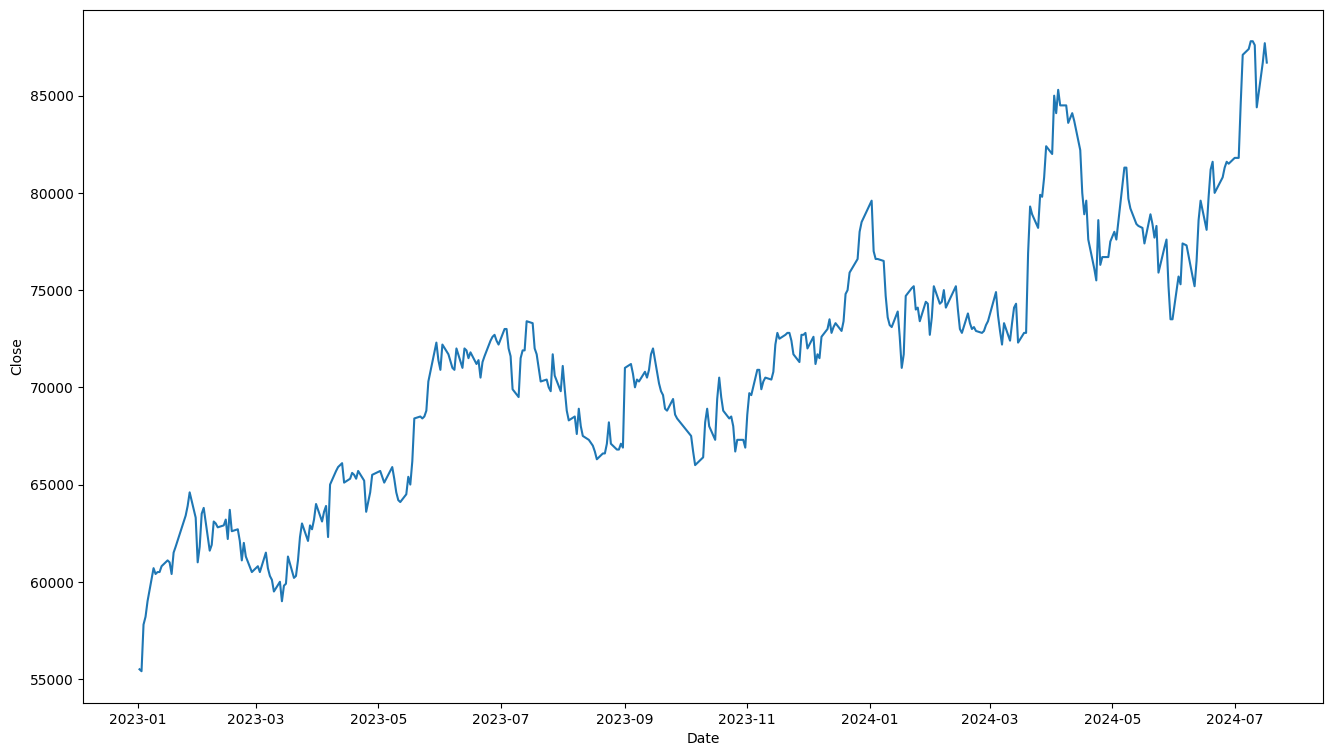

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [31]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']]) # min, max를 이용해서 정규화, 스케일링 진행
print(f'After MinMaxScaling, the max became {df["Close"].max()} while the min became {df["Close"].min()}')
df.tail()

After MinMaxScaling, the max became 1.0 while the min became 0.0


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-07-11,1.000000,1.000000,0.987730,0.993827,0.363490,-0.002278
2024-07-12,0.921450,0.917683,0.907975,0.895062,0.395625,-0.036530
2024-07-15,0.885196,0.954268,0.907975,0.966049,0.373428,0.027251
2024-07-16,0.951662,0.975610,0.987730,0.996914,0.199397,0.011534
2024-07-17,0.957704,0.975610,0.978528,0.966049,0.229838,-0.011403


In [32]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length): # seq_len = 5 -> 1일차부터 5일씩 묶을 수 있는 마지막 지점까지
    x_seq.append(x[ i : i + sequence_length]) # 첫날~5일치 , 둘째 날~5일치 이런 식으로 추가해 넣어
    y_seq.append(y[i + sequence_length]) # 5일치의 값을 집어넣기

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [33]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 200개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([174, 5, 4]) torch.Size([174, 1])


In [34]:
x_train_seq

tensor([[[0.0030, 0.0030, 0.0215, 0.0811],
         [0.0000, 0.0000, 0.0000, 0.1489],
         [0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219]],

        [[0.0000, 0.0000, 0.0000, 0.1489],
         [0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471]],

        [[0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471],
         [0.1450, 0.1555, 0.1656, 0.1742]],

        ...,

        [[0.4018, 0.3994, 0.4202, 0.1119],
         [0.4018, 0.3902, 0.4049, 0.1343],
         [0.4048, 0.3902, 0.4110, 0.0923],
         [0.3505, 0.3628, 0.3742, 0.1869],
         [0.3535, 0.3445, 0.3742, 0.1062]],

        [[0.4018, 0.3902, 0.4049, 0.1343],
         [0.4048, 0.3902, 0.4110, 0.0923],
         [0.3505, 0.3628, 0.3742

In [35]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

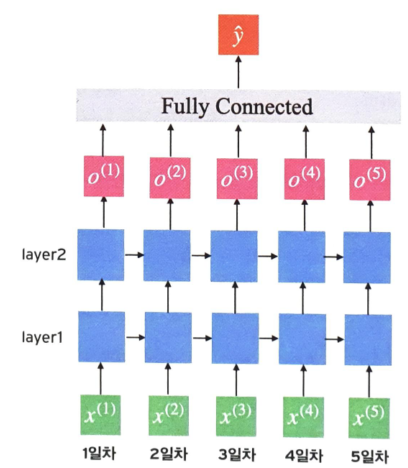

In [36]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [37]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [38]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [39]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [40]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0235
[epoch : 10] loss: 0.0020
[epoch : 20] loss: 0.0018
[epoch : 30] loss: 0.0016
[epoch : 40] loss: 0.0015


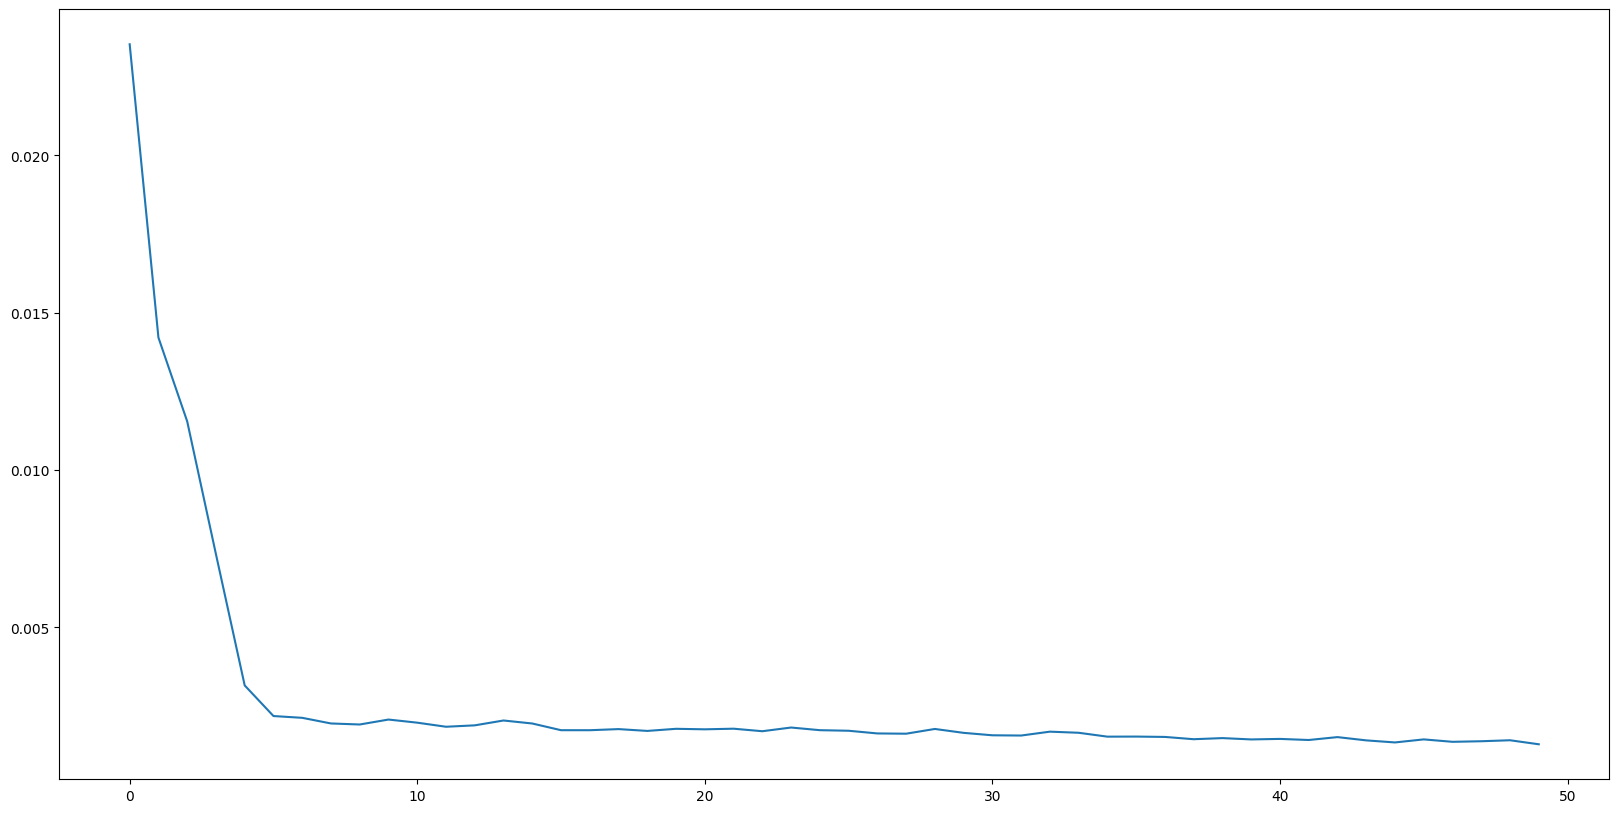

In [41]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [42]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

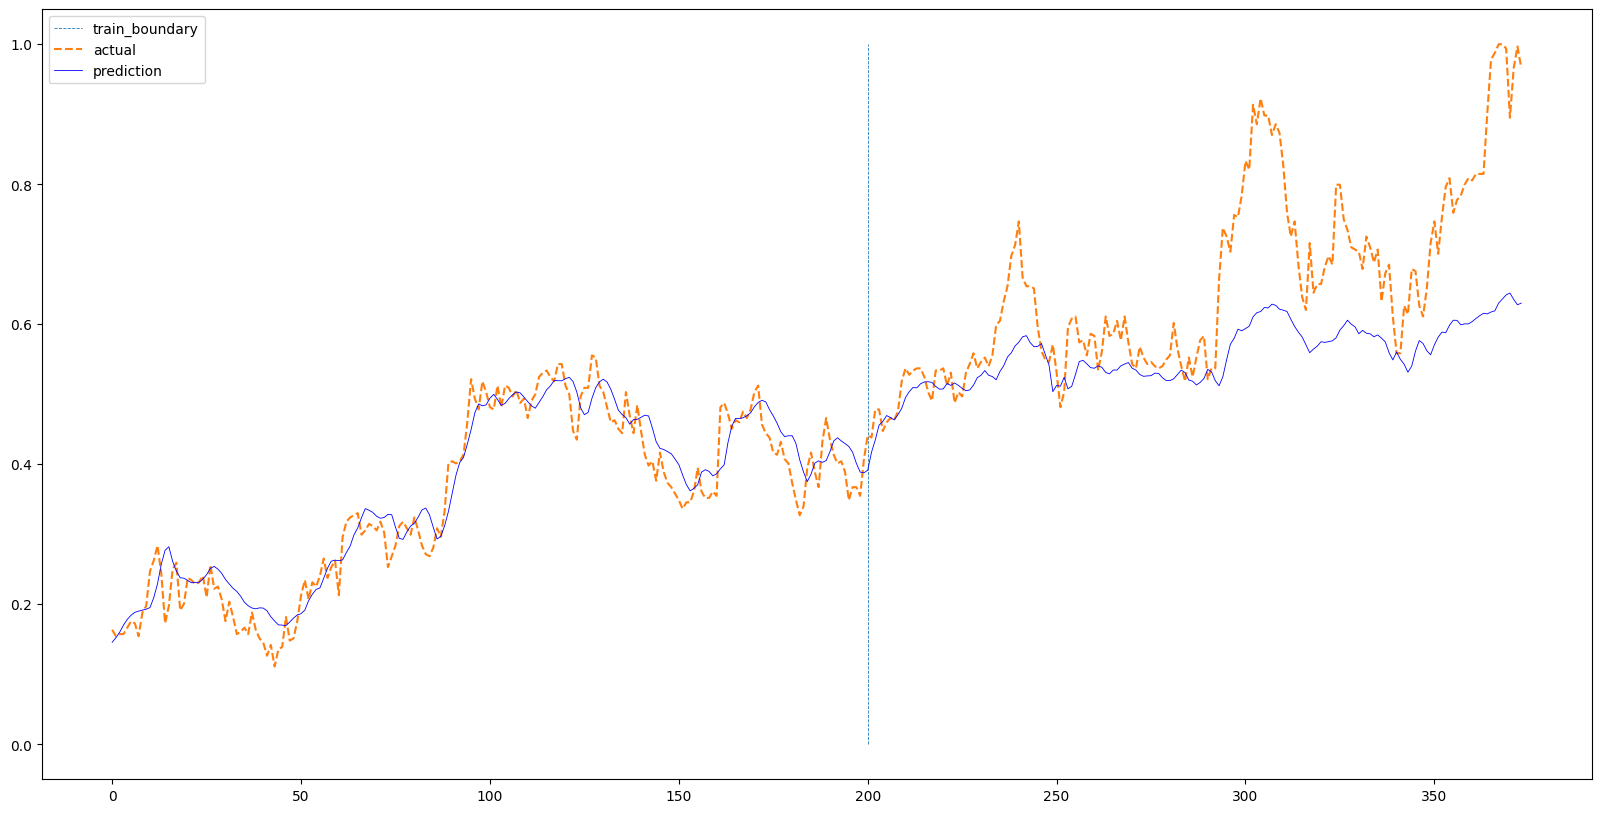

In [43]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [44]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [45]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [46]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [47]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [48]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.1443
[epoch: 10] loss: 0.0019
[epoch: 20] loss: 0.0018
[epoch: 30] loss: 0.0017
[epoch: 40] loss: 0.0017


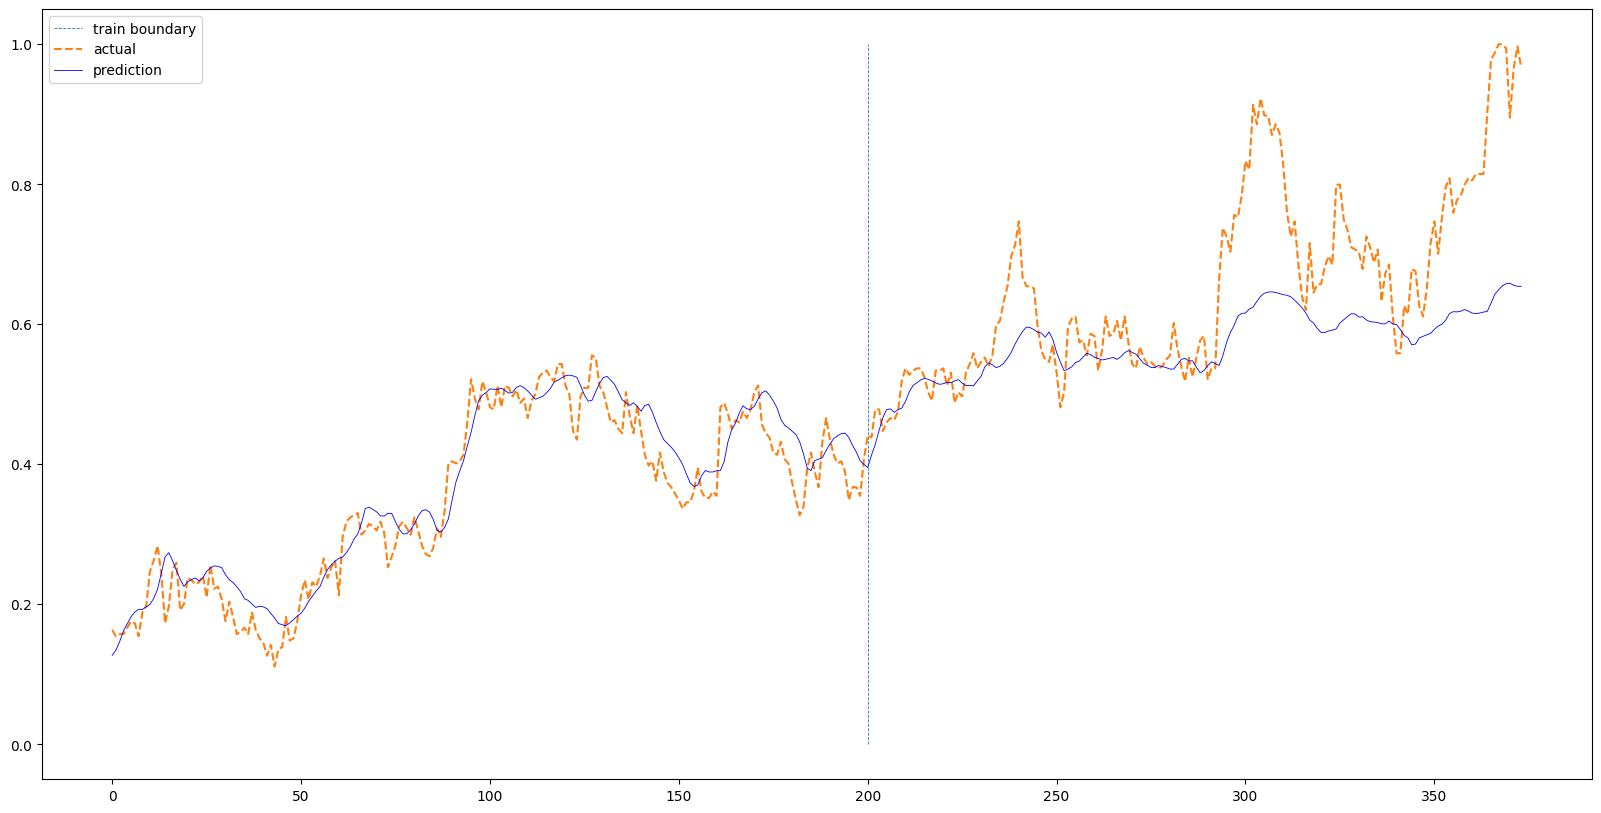

In [49]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

- 세션 들은 뒤에 코드 이해하고 시도해보려 합니다!

In [ ]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2023-01-01', '2024-12-31')
df.tail